# RANSAC Regression Algorithm

# Load data
This is just a reuse of the Sklearn example:

https://scikit-learn.org/stable/auto_examples/linear_model/plot_ransac.html


Estimated coefficients (true, linear regression, RANSAC):
82.1903908407869 [54.17236387] [82.08533159]


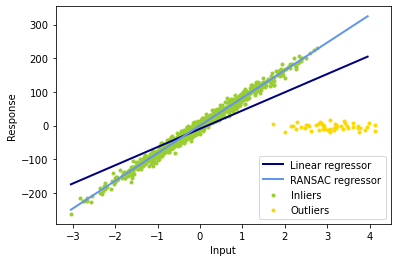

In [1]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn import linear_model, datasets


n_samples = 1000
n_outliers = 50


X, y, coef = datasets.make_regression(n_samples=n_samples, n_features=1,
                                      n_informative=1, noise=10,
                                      coef=True, random_state=0)

# Add outlier data
np.random.seed(0)
X[:n_outliers] = 3 + 0.5 * np.random.normal(size=(n_outliers, 1))
y[:n_outliers] = -3 + 10 * np.random.normal(size=n_outliers)

# Fit line using all data
lr = linear_model.LinearRegression()
lr.fit(X, y)

# Robustly fit linear model with RANSAC algorithm
ransac = linear_model.RANSACRegressor()
ransac.fit(X, y)
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

# Predict data of estimated models
line_X = np.arange(X.min(), X.max())[:, np.newaxis]
line_y = lr.predict(line_X)
line_y_ransac = ransac.predict(line_X)

# Compare estimated coefficients
print("Estimated coefficients (true, linear regression, RANSAC):")
print(coef, lr.coef_, ransac.estimator_.coef_)

lw = 2
plt.scatter(X[inlier_mask], y[inlier_mask], color='yellowgreen', marker='.',
            label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask], color='gold', marker='.',
            label='Outliers')
plt.plot(line_X, line_y, color='navy', linewidth=lw, label='Linear regressor')
plt.plot(line_X, line_y_ransac, color='cornflowerblue', linewidth=lw,
         label='RANSAC regressor')
plt.legend(loc='lower right')
plt.xlabel("Input")
plt.ylabel("Response")
plt.show()

# RANSAC

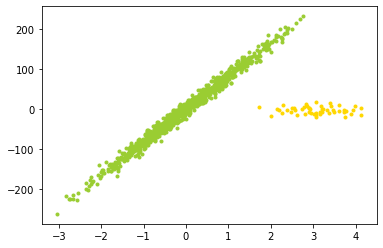

In [2]:
plt.scatter(X[inlier_mask], y[inlier_mask], color='yellowgreen', marker='.',
            label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask], color='gold', marker='.',
            label='Outliers')
plt.show()

**Compute residual threshold**

According to sklearn documentation, the residual threshold for RANSAC is mean absolute deviation (MAD) of y.

In [50]:
from scipy import stats
import numba
residual_threshold = stats.median_abs_deviation(y)
print(f"Residual threshold is {residual_threshold}.")

Residual threshold is 51.064948575086504.


Residual threshold is 51.064948575086504.


# Explore

In [62]:
n_samples = len(y)

@numba.njit()
def one_run(i, j):
    # build a model with Point I and Point J
    slope = (y[i] - y[j]) / (X[i][0] - X[j][0])
    # y = ax + b
    # b = y - ax
    intercept = y[i] - slope * X[i][0]
    
    # Count number of inliers
    
    inliers = []
    for k in range(n_samples):
        y_hat = slope * X[k][0] + intercept
        if y[k] > y_hat - residual_threshold and y[k] < y_hat + residual_threshold:
            inliers.append(k)
    
    return slope, intercept, inliers
    
def plot_one_run(i, j):
    slope, intercept, inliers = one_run(i, j)
    print(f"Slope: {slope}, Intercept: {intercept}, and #Inliers: {len(inliers)}") 
    y_hat = [slope * x[0] + intercept for x in X]
    y_upper = y_hat - residual_threshold
    y_lower = y_hat + residual_threshold
    
    plt.figure(figsize=(10, 6))
    plt.scatter(X[inlier_mask], y[inlier_mask], color='yellowgreen', marker='.',
                label='Inliers')

    plt.scatter(X[outlier_mask], y[outlier_mask], color='gold', marker='.',
                label='Outliers')
    
    plt.plot(X, y_hat, color='purple', label="fitted line by samples")
    plt.plot(X, y_upper, "--", color='blue', label="upper bound")
    plt.plot(X, y_lower, "--", color='blue', label="lower bound")
    
    if len(inliers)>500:
        X_inliers = X[inliers]
        y_inliers = y[inliers]
        base_estimator = linear_model.LinearRegression()
        base_estimator.fit(X_inliers, y_inliers)
        y_hat = base_estimator.predict(X)
        plt.plot(X, y_hat, color='black', label="fitted line by inliers")
    
    plt.scatter(X[[i,j]], y[[i,j]], color='red', marker='o',
                label='sample points')
    plt.legend()
    plt.title(f"Point {i} and {j}")
    plt.show()

Slope: -31.031367548715302, Intercept: 100.17184032979411, and #Inliers: 260


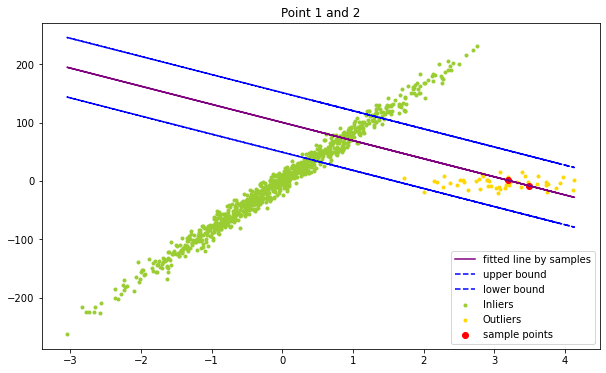

In [63]:
plot_one_run(1, 2)

Slope: 87.42882074717447, Intercept: -2.2013221925125954, and #Inliers: 950


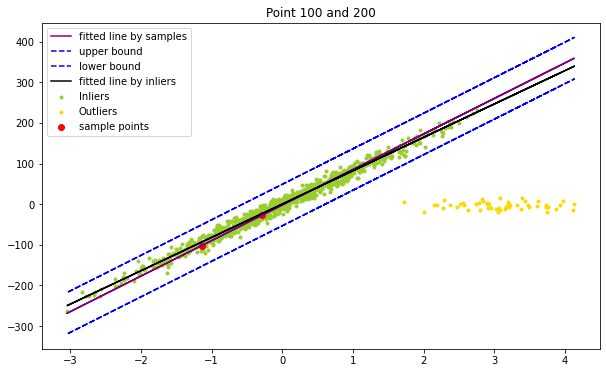

In [64]:
plot_one_run(100, 200)

In [68]:
# for i in range(50,150):
#     plot_one_run(100, i)

Slope: 23.675082207570938, Intercept: -74.89309904614325, and #Inliers: 380


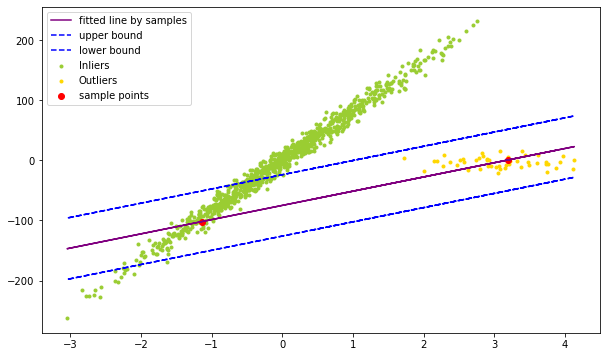

In [51]:
plot_one_run(1, 200)

# Put it together


In [46]:
import random

# this is copied from sklearn:
# https://github.com/scikit-learn/scikit-learn/blob/2beed5584/sklearn/linear_model/_ransac.py#L23
_EPSILON = np.spacing(1)
def dynamic_max_trials(n_inliers, n_samples, min_samples, probability):
    """Determine number trials such that at least one outlier-free subset is
    sampled for the given inlier/outlier ratio.
    Parameters
    ----------
    n_inliers : int
        Number of inliers in the data.
    n_samples : int
        Total number of samples in the data.
    min_samples : int
        Minimum number of samples chosen randomly from original data.
    probability : float
        Probability (confidence) that one outlier-free sample is generated.
    Returns
    -------
    trials : int
        Number of trials.
    """
    inlier_ratio = n_inliers / float(n_samples)
    nom = max(_EPSILON, 1 - probability)
    denom = max(_EPSILON, 1 - inlier_ratio ** min_samples)
    if nom == 1:
        return 0
    if denom == 1:
        return float('inf')
    return abs(float(np.ceil(np.log(nom) / np.log(denom))))

@numba.njit()
def get_model_inliers(i, j):
    # build a model with Point I and Point J
    slope = (y[i] - y[j]) / (X[i][0] - X[j][0])
    # y = ax + b
    # b = y - ax
    intercept = y[i] - slope * X[i][0]
    
    # Count number of inliers
    
    inliers = []
    for k in range(n_samples):
        y_hat = slope * X[k][0] + intercept
        if y[k] > y_hat - residual_threshold and y[k] < y_hat + residual_threshold:
            inliers.append(k)
    
    return slope, intercept, inliers

@numba.njit()
def sampling():
    i = random.randint(0, len(y))
    j = random.randint(0, len(y))
    while i == j:
        j = random.randint(0, len(y))
    if j>i:
        i, j=j, i 
    return i, j

def ransac(X, y):
    n_samples = len(y)
    max_n_inliers = 0
    best_slope = 0
    best_intercept = 0
    best_inliers = []
    iterations = 0
    best_model = None
    best_score = 0
    N = 100
    while iterations < N:
        print(f"-----------------------------iterations {iterations}----------------------------")
        i, j = sampling()
        slope, intercept, inliers = get_model_inliers(i, j)
        if len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_slope = slope
            best_intercept = intercept
        
        iterations += 1
        
        if len(inliers)>500:
            X_inliers = X[inliers]    
            y_inliers = y[inliers]   
            model = linear_model.LinearRegression()
            model.fit(X_inliers, y_inliers)
            score = model.score(X_inliers, y_inliers)
            if score > best_score:
                print(iterations, score)
                best_model = model
                best_score = score
        
        N = dynamic_max_trials(len(best_inliers), 1000, 2, 0.99)
        print(f"#n_liers: {len(inliers)}, #best_n_inliers: {len(best_inliers)}, best score: {best_score}")
        
    print(f"quit after {iterations} iterations")
    
    return best_model, best_inliers

In [79]:
final_model, best_inliers = ransac(X, y)

-----------------------------iterations 0----------------------------
1 0.9793338725607942
#n_liers: 842, #best_n_inliers: 842, best score: 0.9793338725607942
-----------------------------iterations 1----------------------------
#n_liers: 129, #best_n_inliers: 842, best score: 0.9793338725607942
-----------------------------iterations 2----------------------------
#n_liers: 633, #best_n_inliers: 842, best score: 0.9793338725607942
-----------------------------iterations 3----------------------------
4 0.9848858721264135
#n_liers: 950, #best_n_inliers: 950, best score: 0.9848858721264135
quit after 4 iterations


In [48]:
y_my_ransac = final_model.predict(X)

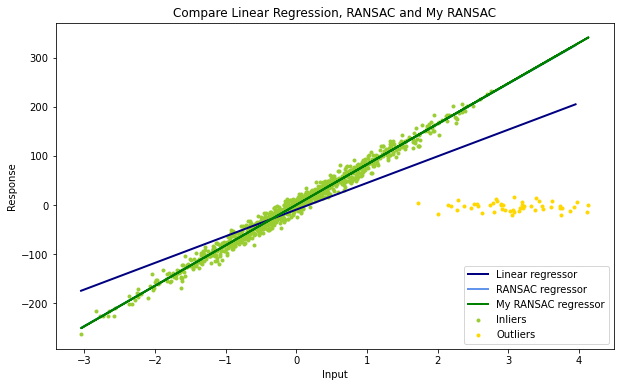

In [49]:
lw = 2
plt.figure(figsize=(10, 6))
plt.scatter(X[inlier_mask], y[inlier_mask], color='yellowgreen', marker='.',
            label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask], color='gold', marker='.',
            label='Outliers')
plt.plot(line_X, line_y, color='navy', linewidth=lw, label='Linear regressor')
plt.plot(line_X, line_y_ransac, color='cornflowerblue', linewidth=lw,
         label='RANSAC regressor')
plt.plot(X, y_my_ransac, color='green', linewidth=lw,
         label='My RANSAC regressor')
plt.legend(loc='lower right')
plt.xlabel("Input")
plt.ylabel("Response")
plt.title("Compare Linear Regression, RANSAC and My RANSAC")
plt.show()